In this notebook, I'm going to attempt a new tack for my analysis. 

In [162]:
from statannotations.Annotator import Annotator
import scienceplots
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [163]:
plt.style.use('science')

# Get the hex codes for the colors so we can assign them to categories
pal = sns.color_palette('Paired')
print(pal.as_hex())

# Set the color palette. Our categories are "Single Domain", "Two-Domain", and "Autoinhibitory"
# THis is the color palette for only experimental proteins
colors = {'Single Domain': pal[0], 'Two-Domain': pal[9], 'Autoinhibitory': pal[5], 'Autoinhibitory (Active)': pal[2], 'Autoinhibitory (Autoinhibited)': pal[3], 
          'Full': pal[3], 'Clusters': pal[7], 'Two-State AI': pal[4], 'Autoinhibitory (Closed)': pal[5], 'Autoinhibitory (Open)': pal[4], 'Obligate': pal[7]}
pal.as_hex()

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

## What is the distribution of the maximum and minimum IMAE per protein?

In [164]:
df = pd.read_csv('./project_pipeline/data/ai_intra_experimental_rmsds.tsv', sep='\t')

df = df.drop(columns=['Unnamed: 0'])
df = df.rename(columns={'2_comp': 'IMAE'})
df.head()

,IMAE,ref_pdb,pdb,complex_rmsd,uniprot
0,0.671,8aoi,1pme,19.803,P28482
1,0.946,8aoi,1tvo,7.874,P28482
2,2.799,8aoi,1wzy,7.892,P28482
3,8.458,8aoi,2y9q,5.208,P28482
4,0.537,8aoi,3sa0,9.858,P28482


In [165]:
# Find the max and min IMAE per protein and create a new dataframe with the difference between those two values
df_max = df.groupby('uniprot')['IMAE'].max().reset_index()
df_min = df.groupby('uniprot')['IMAE'].min().reset_index().drop_duplicates(keep='first')
df_diff = pd.merge(df_max, df_min, on='uniprot')
df_diff['diff'] = df_diff['IMAE_x'] - df_diff['IMAE_y']
df_diff = df_diff.sort_values('diff', ascending=False)
df_diff.head()

,uniprot,IMAE_x,IMAE_y,diff
61,Q96P20,79.596,1.858,77.738
40,Q00944,70.824,2.192,68.632
43,Q06124,58.631,0.525,58.106
51,Q6SZW1,52.837,4.648,48.189
26,P35520,50.552,3.642,46.910


Now that we've seen the distribution (deleted), how many proteins do we have with differences greater than 3? We use 3 as our cutoff because that's the "crystallographic" cutoff, if you will.

We know from some data wrangling (that we have now deleted) that there's a pretty heavy overlap between the proteins with both active and autoinhibitory states and our proteins. So, we're going to focus on the two max and min structures per protein.

In [166]:
df_smol = df_diff[['uniprot', 'diff']]
df_max = pd.merge(df, df_max, on=['uniprot', 'IMAE'])
df_min = pd.merge(df, df_min, on=['uniprot', 'IMAE'])
bounds = pd.concat([df_max, df_min])
g3 = pd.merge(bounds, df_smol, on='uniprot')

g3.head()

,IMAE,ref_pdb,pdb,complex_rmsd,uniprot,diff
0,17.205,8aoi,4qp9,13.505,P28482,17.062
1,0.143,8aoi,8aoc,3.427,P28482,17.062
2,40.971,5uww,7mns,16.358,P62826,40.506
3,0.465,5uww,5uwq,0.342,P62826,40.506
4,11.742,2xba,8arj,18.928,Q9UM73,11.202


In [167]:
g3.shape

(142, 6)

In [81]:
# # Create a new columns, num_states, that is the number of states per protein
# val_counts = df.groupby('uniprot')['state'].nunique().reset_index()
# val_counts = val_counts.rename(columns={'state': 'num_states'})
# df = pd.merge(df, val_counts, on='uniprot')

In [82]:
# # Create a new column, num_confs, that is the number of conformations per protein
# val_counts = df.groupby('uniprot')['conformation'].nunique().reset_index()
# val_counts = val_counts.rename(columns={'conformation': 'num_confs'})
# df = pd.merge(df, val_counts, on='uniprot')
# s_c = df[['uniprot', 'num_states', 'num_confs']].drop_duplicates()

In [83]:
# g3 = pd.merge(g3, s_c, on='uniprot', how='left')

In [168]:
# How many proteins do we have with a difference greater than 3? How about ten?

# Greater than 3
g3 = g3[g3['diff'] > 3]
print('The number of proteins with a difference between min and max IMAE greater than 3 is ' + str(g3['uniprot'].nunique()))
# print('The number of structures with no annotated state in this group is: ' + str(g3['state'].isnull().sum()))

The number of proteins with a difference between min and max IMAE greater than 3 is 35


In [85]:
# # How many proteins do we have with a difference greater than 3 and 0 states?
# not_an = df[(df['diff'] > 3) & (df['num_states'] == 0)]
# print(not_an['uniprot'].unique())

In [86]:
# # For those proteins with differences greater than 3, what are the state and conformation annotations?
# grouped = g3.groupby('uniprot')['state'].value_counts()
# grouped


In [87]:
# nan = g3[g3['state'].isnull()]
# nan.head(15)

We have 17 proteins with two annotated states, 10 proteins with 1 annotated state, and 2 proteins with 0 annotated states. 

## Analyzing our Proteins of Interest with DockQ

In [169]:
dq = pd.read_csv('./project_pipeline/data/ai_pdb_full_depth_dockq.csv')

In [170]:
g3d = pd.merge(g3, dq, on=['uniprot', 'pdb'], how='left')
g3d.head()

,IMAE,ref_pdb,pdb,complex_rmsd,uniprot,diff,fnat,fnat_correct,fnat_total,fnonnat,fnonnat_nnative,fnonnat_model,irms,lrms,dockq,capri
0,17.205,8aoi,4qp9,13.505,P28482,17.062,0.754,49.0,65.0,0.183,11.0,60.0,1.368,2.440,0.741,Medium
1,0.143,8aoi,8aoc,3.427,P28482,17.062,0.831,59.0,71.0,0.454,49.0,108.0,2.532,5.842,0.590,Medium
2,40.971,5uww,7mns,16.358,P62826,40.506,0.000,0.0,2.0,1.000,67.0,67.0,4.206,60.985,0.044,Incorrect
3,0.465,5uww,5uwq,0.342,P62826,40.506,0.500,1.0,2.0,0.667,2.0,3.0,1.120,39.437,0.396,Acceptable
4,11.742,2xba,8arj,18.928,Q9UM73,11.202,0.909,40.0,44.0,0.245,13.0,53.0,2.333,2.978,0.697,Medium


## Compare with Multi-Domain proteins

In [172]:
md = pd.read_csv('./project_pipeline/data/md_intra_experimental_rmsds.tsv', sep='\t')
obli = pd.read_csv('./project_pipeline/data/obligate.tsv', sep='\t')

md = md.drop(columns=['Unnamed: 0'])
md = md.rename(columns={'2_comp': 'IMAE'})
md.head()

,IMAE,ref_pdb,pdb,complex_rmsd,uniprot
0,0.019,6ur2,3ht3,0.093,D9N168
1,0.001,6ur2,4o0i,0.042,D9N168
2,0.019,6ur2,6ueu,0.579,D9N168
3,0.075,6ur2,6ur4,0.000,D9N168
4,0.185,6ur2,6ur9,0.706,D9N168


In [181]:
# Find the max and min IMAE per protein and create a new dataframe with the difference between those two values
md_max = md.groupby('uniprot')['IMAE'].max().reset_index()
md_min = md.groupby('uniprot')['IMAE'].min().reset_index().drop_duplicates(keep='first')
md_diff = pd.merge(md_max, md_min, on='uniprot')
md_diff['diff'] = md_diff['IMAE_x'] - md_diff['IMAE_y']
md_diff

,uniprot,IMAE_x,IMAE_y,diff
0,A0A0A0V031,58.203,0.260,57.943
1,A0A0F7R6G7,52.101,0.029,52.072
2,A0A0H2WY27,0.690,0.036,0.654
3,A0A140DJY3,0.141,0.047,0.094
4,D9N168,0.420,0.001,0.419
5,E1K248,0.119,0.007,0.112
6,F2Z6J5,0.027,0.027,0.000
7,G0WVH3,0.125,0.012,0.113
8,H2E7Q8,14.474,0.005,14.469
9,H6SG27,1.500,1.500,0.000


In [177]:
multi_df = g3d['uniprot'].unique()

multi_md = md_diff[md_diff['diff'] > 3]
multi_md = multi_md['uniprot'].unique()

Text(0.5, 0, 'Difference between max and min IMAE')

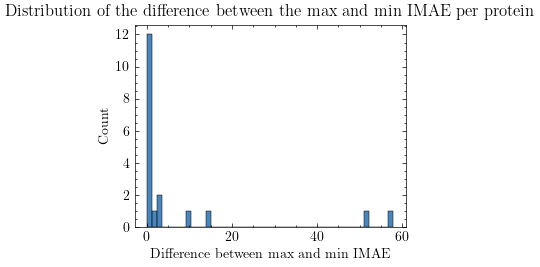

In [182]:
not_zero = md_diff[md_diff['diff'] != 0]

fig, ax = plt.subplots()
sns.histplot(not_zero['diff'], bins=50)
ax.set_title('Distribution of the difference between the max and min IMAE per protein')
ax.set_xlabel('Difference between max and min IMAE')

We can compare the two in a boxplot


In [183]:
df_diff['type'] = 'Autoinhibitory'
md_diff['type'] = 'Two-Domain'

# Select obligate proteins as well
obligate_uniprots = obli['uniprot'].unique().tolist()
obli_diff = md_diff[md_diff['uniprot'].isin(obligate_uniprots)]
obli_diff['type'] = 'Obligate'

# Keep only proteins with multiple structures. Having proteins with only one structure renders the comparison moot.

diffs = pd.concat([df_diff, md_diff, obli_diff])
diffs['type'].value_counts()

/tmp/ipykernel_4061328/1477491337.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obli_diff['type'] = 'Obligate'


Autoinhibitory    71
Two-Domain        28
Obligate           6
Name: type, dtype: int64

Are our variances different?

In [185]:
sp.stats.levene(df_diff['diff'], md_diff['diff'], obli_diff['diff'])

LeveneResult(statistic=1.5612975501337913, pvalue=0.21483696584904982)

/tmp/ipykernel_4061328/1114918665.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Autoinhibitory vs. Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:7.433e-02 U_stat=1.220e+03
Two-Domain vs. Obligate: Mann-Whitney-Wilcoxon test two-sided, P_val:9.453e-01 U_stat=8.200e+01
Autoinhibitory vs. Obligate: Mann-Whitney-Wilcoxon test two-sided, P_val:2.371e-01 U_stat=2.745e+02


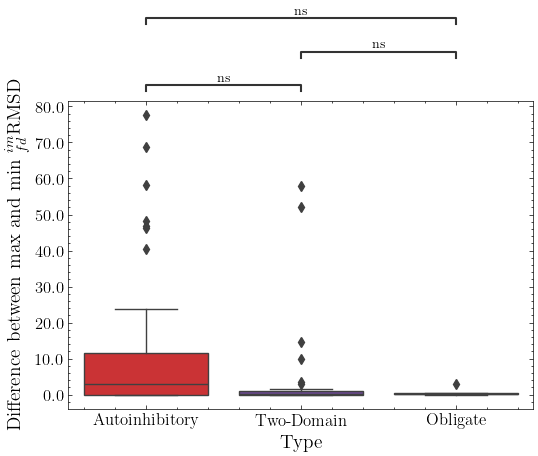

In [187]:
fig, ax = plt.subplots(figsize=(6, 4))

params = {'mathtext.default': 'regular'}
sns.boxplot(data=diffs, x='type', y='diff', palette=colors)
ax.set_xlabel('Type', fontsize=14)
ax.set_ylabel('Difference between max and min $_{fd}^{im}$RMSD', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticks(), fontsize=12)

# Annotate statistical significance
pairs = [('Autoinhibitory', 'Two-Domain'),
         ('Autoinhibitory', 'Obligate'),
         ('Two-Domain', 'Obligate')]

annotator = Annotator(ax, pairs, data=diffs, x='type', y='diff', palette='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/imae_structure_spread.png')

In [96]:
diffs.head(10)

,uniprot,IMAE_x,IMAE_y,diff,type
107,Q96P20,80.422,6.447,73.975,Autoinhibitory
62,Q00944,71.123,1.906,69.217,Autoinhibitory
66,Q06124,58.638,0.770,57.868,Autoinhibitory
35,P29350,57.427,1.765,55.662,Autoinhibitory
5,O08967,54.034,1.593,52.441,Autoinhibitory
89,Q6SZW1,52.996,2.948,50.048,Autoinhibitory
126,Q9Y6K1,47.330,1.268,46.062,Autoinhibitory
21,P12931,47.288,2.074,45.214,Autoinhibitory
60,P62826,69.520,30.840,38.680,Autoinhibitory
32,P26358,36.219,2.180,34.039,Autoinhibitory


## How many "conformations" are there per protein?

In [188]:
def assign_bins(df, bin_size=3):
    '''
    Assigns bins to the IMAE values of the dataframe, based on the bin_size provided.
    '''
    bins_info = []

    for protein in df['uniprot'].unique():
        protein_df = df[df['uniprot'] == protein]
        min_val = protein_df['IMAE'].min()
        max_val = protein_df['IMAE'].max()
        bins = np.arange(min_val, max_val + bin_size, bin_size)
        labels = range(len(bins) - 1)

        protein_df['bin'] = pd.cut(protein_df['IMAE'], bins=bins, labels=labels, include_lowest=True)
        protein_df['bin_id'] = protein + '_' + protein_df['bin'].astype('str')

        bins_info.append(protein_df)

    return pd.concat(bins_info)

In [190]:
# ai_df2 = df[df['uniprot'].isin(multi_df)]
# md_df2_m = md[md['uniprot'].isin(multi_md)]
# md_df2_no_o = md_df2_m[~md_df2_m['uniprot'].isin(obligate_uniprots)]

ai_df2 = df.copy()
ai_df2['type'] = 'Autoinhibitory'

md_df2 = md.copy()
md_df2_no_o = md_df2[~md_df2['uniprot'].isin(obligate_uniprots)]

obli_df2 = pd.merge(md_df2, obli_diff[['uniprot', 'diff', 'type']], on='uniprot')
md_df2 = pd.merge(md_df2_no_o, md_diff[['uniprot', 'diff', 'type']], on='uniprot')


# Assign bins to the dataframes
ai_df2 = assign_bins(ai_df2)
md_df2 = assign_bins(md_df2)
obli_df2 = assign_bins(obli_df2)

# Get rid of unnecessary columns in md_df2 and obli_df2
md_df2 = md_df2[['uniprot', 'pdb', 'complex_rmsd', 'ref_pdb', 'IMAE', 'type', 'bin', 'bin_id']]
obli_df2 = obli_df2[['uniprot', 'pdb', 'complex_rmsd', 'ref_pdb', 'IMAE', 'type', 'bin', 'bin_id']]

# Concatenate the dataframes
all_df = pd.concat([ai_df2, md_df2, obli_df2])
all_df.head()

/tmp/ipykernel_4061328/4153892630.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df['bin'] = pd.cut(protein_df['IMAE'], bins=bins, labels=labels, include_lowest=True)
/tmp/ipykernel_4061328/4153892630.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df['bin_id'] = protein + '_' + protein_df['bin'].astype('str')
/tmp/ipykernel_4061328/4153892630.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,IMAE,ref_pdb,pdb,complex_rmsd,uniprot,type,bin,bin_id
0,0.671,8aoi,1pme,19.803,P28482,Autoinhibitory,0.0,P28482_0
1,0.946,8aoi,1tvo,7.874,P28482,Autoinhibitory,0.0,P28482_0
2,2.799,8aoi,1wzy,7.892,P28482,Autoinhibitory,0.0,P28482_0
3,8.458,8aoi,2y9q,5.208,P28482,Autoinhibitory,2.0,P28482_2
4,0.537,8aoi,3sa0,9.858,P28482,Autoinhibitory,0.0,P28482_0


In [191]:
all_df['uniprot'].nunique()

99

In [192]:
# Find the max number of bins per protein
max_bins = all_df.groupby('uniprot')['bin'].max().reset_index()
max_bins = max_bins.rename(columns={'bin': 'max_bin'})

# Merge the max_bins with all_df
all_df = pd.merge(all_df, max_bins, on='uniprot')
all_df.head()

,IMAE,ref_pdb,pdb,complex_rmsd,uniprot,type,bin,bin_id,max_bin
0,0.671,8aoi,1pme,19.803,P28482,Autoinhibitory,0.0,P28482_0,5.0
1,0.946,8aoi,1tvo,7.874,P28482,Autoinhibitory,0.0,P28482_0,5.0
2,2.799,8aoi,1wzy,7.892,P28482,Autoinhibitory,0.0,P28482_0,5.0
3,8.458,8aoi,2y9q,5.208,P28482,Autoinhibitory,2.0,P28482_2,5.0
4,0.537,8aoi,3sa0,9.858,P28482,Autoinhibitory,0.0,P28482_0,5.0


In [193]:
auto_max_bins = all_df[all_df['type'] == 'Autoinhibitory']['max_bin'].value_counts()
two_max_bins = all_df[all_df['type'] == 'Two-Domain']['max_bin'].value_counts()
obli_max_bins = all_df[all_df['type'] == 'Obligate']['max_bin'].value_counts()

sp.stats.levene(auto_max_bins, two_max_bins, obli_max_bins)

LeveneResult(statistic=3.1190808227887032, pvalue=0.06869979618307934)

/tmp/ipykernel_4061328/2310591243.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Autoinhibitory vs. Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:5.956e-02 U_stat=4.455e+02
Two-Domain vs. Obligate: Mann-Whitney-Wilcoxon test two-sided, P_val:1.518e-01 U_stat=4.750e+01
Autoinhibitory vs. Obligate: Mann-Whitney-Wilcoxon test two-sided, P_val:6.692e-03 U_stat=2.075e+02


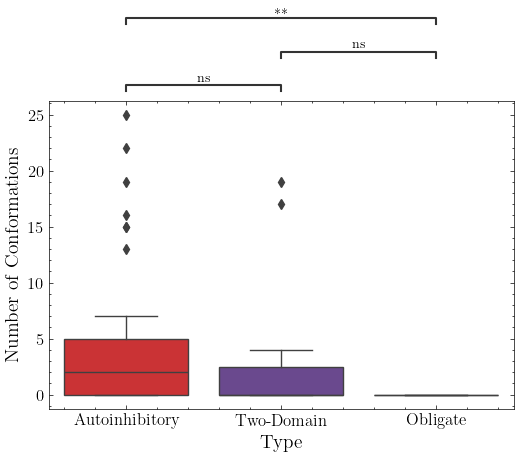

In [194]:
to_plot = all_df[['uniprot', 'type', 'max_bin']].drop_duplicates().reset_index(drop=True)

fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(data=to_plot, x='type', y='max_bin', palette=colors)
ax.set_xlabel('Type', fontsize=14)
ax.set_ylabel('Number of Conformations', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

# Annotate statistical significance
pairs = [('Autoinhibitory', 'Two-Domain'),
         ('Autoinhibitory', 'Obligate'),
         ('Two-Domain', 'Obligate')]

annotator = Annotator(ax, pairs, data=to_plot, x='type', y='max_bin', palette='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/number_of_protein_conformations.png')

There doesn't seem to be a statistical significcance between the three groups because of how many proteins in all groups have only one conformation.

In [195]:
to_plot['type'].value_counts()

Autoinhibitory    71
Two-Domain        22
Obligate           6
Name: type, dtype: int64

## Does having partners, nonstandard monomers, or non-polymers matter for performance?

In [104]:
# As everything below concerns the comparisons to the full-depth structures, we change the colors back to match.
colors = {'Single Domain': pal[0], 'Two-Domain': pal[1], 'Autoinhibitory': pal[3], 'Autoinhibitory (Active)': pal[2], 'Autoinhibitory (Autoinhibited)': pal[3], 
          'Full': pal[3], 'Clusters': pal[7], 'Two-State AI': pal[4], 'Autoinhibitory (Closed)': pal[5], 'Autoinhibitory (Open)': pal[4], 'Obligate': pal[6]}
pal.as_hex()

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [196]:
df2 = pd.read_csv('./project_pipeline/data/ai_nonstandard_monomers.tsv', sep='\t')
df2 = df2.rename(columns={'2_comp': 'IMAE'})
df2['type'] = 'Autoinhibitory'
df2 = assign_bins(df2)

all_df = pd.concat([df2, md_df2, obli_df2])

/tmp/ipykernel_4061328/4153892630.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df['bin'] = pd.cut(protein_df['IMAE'], bins=bins, labels=labels, include_lowest=True)
/tmp/ipykernel_4061328/4153892630.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df['bin_id'] = protein + '_' + protein_df['bin'].astype('str')
/tmp/ipykernel_4061328/4153892630.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [207]:
# one_structure_prots = df2['uniprot'].value_counts()
# one_structure_prots = one_structure_prots[one_structure_prots == 1].index.tolist()
# one_struct = df2[df2['uniprot'].isin(one_structure_prots)]

<Axes: xlabel='type', ylabel='IMAE'>

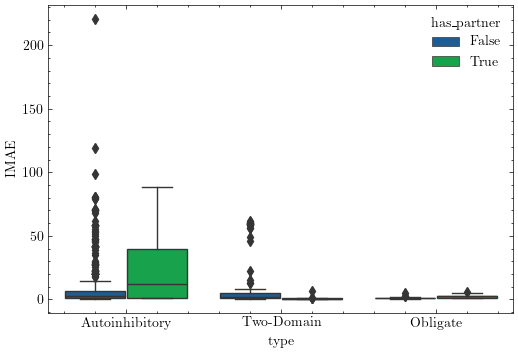

In [106]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(data=all_df, x='type', y='IMAE', hue='has_partner')

<Axes: xlabel='type', ylabel='IMAE'>

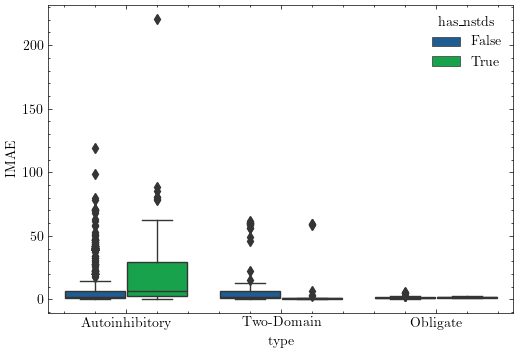

In [107]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(data=all_df, x='type', y='IMAE', hue='has_nstds')

<Axes: xlabel='type', ylabel='IMAE'>

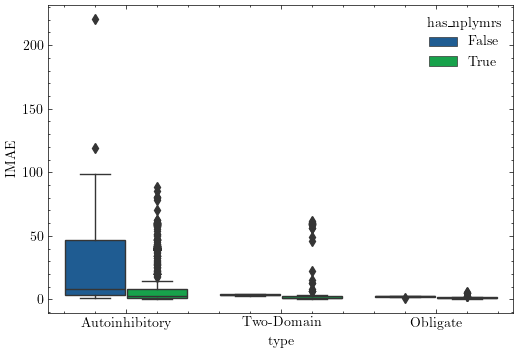

In [108]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(data=all_df, x='type', y='IMAE', hue='has_nplymrs')

In [109]:
all_df.groupby('type')['has_partner'].value_counts()

type            has_partner
Autoinhibitory  False          649
                True           245
Obligate        False           43
                True            15
Two-Domain      False           92
                True            34
Name: has_partner, dtype: int64

## How many interface contacts does each of our important structures above have?

In [110]:
ifc = pd.read_csv('./project_pipeline/data/proteins_interface.tsv', sep='\t')
ifc = ifc[['uniprot', 'pdb', 'number_interface_residues']]
ifc.head()

,uniprot,pdb,number_interface_residues
0,P04637,8f2h,21.0
1,P04637,8f2i,21.0
2,P00523,2ptk,33.0
3,P28482,1pme,70.0
4,P28482,1tvo,68.0


In [111]:
df2 = pd.merge(g3d, ifc, on=['uniprot', 'pdb'])
df2 = df2[['uniprot', 'pdb', 'complex_rmsd', 'IMAE', 'state', 'conformation', 'fnat', 'fnat_total', 'fnonnat', 'dockq', 'capri', 'number_interface_residues', 'num_partners', 'nstds']]
df2['number_interface_residues'] = df2['number_interface_residues'].astype('float')
df2['number_interface_residues'] = df2['number_interface_residues'].fillna(0)
df2['IMAE'] = df2['IMAE'].astype('float')
df2

,uniprot,pdb,complex_rmsd,IMAE,state,conformation,fnat,fnat_total,fnonnat,dockq,capri,number_interface_residues,num_partners,nstds
0,P07038,1mhs,14.225,22.815,Active,Closed,0.000,4.0,1.000,0.075,Incorrect,18.0,0,[]
1,P07038,7nxf,4.914,12.107,Autoinhibited,Closed,0.250,4.0,0.971,0.251,Acceptable,26.0,0,"[""ADENOSINE-5'-DIPHOSPHATE""]"
2,P07038,7ny1,4.914,12.107,Autoinhibited,Closed,0.250,4.0,0.971,0.251,Acceptable,26.0,0,"[""ADENOSINE-5'-DIPHOSPHATE""]"
3,Q8NQJ3,2kb4,30.770,61.982,Active,Open,0.000,0.0,0.000,0.008,Incorrect,0.0,0,[]
4,Q8NQJ3,2kb3,15.371,29.829,Autoinhibited,Closed,0.000,0.0,1.000,0.056,Incorrect,37.0,0,['PHOSPHOTHREONINE']
5,P60240,4s20,11.120,29.595,Autoinhibited,Closed,NaN,NaN,NaN,NaN,NaN,22.0,4,[]
6,P60240,7m8e,5.106,11.303,Active,Open,NaN,NaN,NaN,NaN,NaN,0.0,4,[]
7,A0A0R4I961,6gu0,2.105,4.298,Active,Closed,0.942,69.0,0.015,0.890,High,40.0,1,['methyl alpha-D-mannopyranoside']
8,A0A0R4I961,6gtv,1.450,1.135,Active,Closed,0.913,69.0,0.045,0.927,High,39.0,1,[]
9,P00579,7khi,18.080,51.763,Active,Open,0.000,0.0,0.000,0.013,Incorrect,0.0,5,[]


Get the best structures of all of the proteins with two conformations more than 3 angstroms apart.

In [112]:
min_df2 = df2.groupby('uniprot')['IMAE'].min().reset_index()
min_df2 = pd.merge(df2, min_df2, on=['uniprot', 'IMAE']).drop_duplicates(subset='uniprot')

Get the best structures of the proteins with no variance in the number of partners or phosphorylation state and then concat the two dataframes together for plotting.

In [113]:
n_nstds = df2.groupby('uniprot')['nstds'].nunique()
two_nstds = n_nstds[n_nstds == 1].index

varies_partners = df2.groupby('uniprot')['num_partners'].nunique()
does_not_vary = varies_partners[varies_partners == 1].index

common = set(two_nstds).intersection(set(does_not_vary))

no_vary = df2[df2['uniprot'].isin(common)]

vary_min = min_df2[~min_df2['uniprot'].isin(common)]
vary_min['type'] = 'Variant'

no_vary_min = no_vary.groupby('uniprot')['IMAE'].min().reset_index()
no_vary_min = pd.merge(no_vary, no_vary_min, on=['uniprot', 'IMAE']).drop_duplicates(subset='uniprot')

no_vary_min['type'] = 'Invariant'

compare_vary_no_vary = pd.concat([no_vary_min, vary_min]).reset_index(drop=True)

/tmp/ipykernel_4061328/2657711665.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vary_min['type'] = 'Variant'


In [114]:
sp.stats.levene(no_vary_min['IMAE'], vary_min['IMAE'])

LeveneResult(statistic=0.2224865299088055, pvalue=0.6409413734079883)

In [115]:
compare_vary_no_vary['IMAE'] = compare_vary_no_vary['IMAE'].astype('float')

/tmp/ipykernel_4061328/1520326124.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Invariant vs. Variant: Mann-Whitney-Wilcoxon test two-sided, P_val:6.140e-01 U_stat=9.200e+01


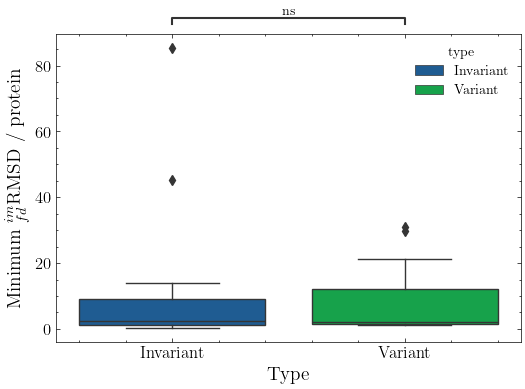

In [116]:
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(data=compare_vary_no_vary, x='type', y='IMAE', hue='type', dodge=False)
ax.set_xlabel('Type', fontsize=14)
ax.set_ylabel('Minimum $_{fd}^{im}$RMSD / protein', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

# Annotate statistical significance
pairs = [('Invariant', 'Variant')]

annotator = Annotator(ax, pairs, data=compare_vary_no_vary, x='type', y='IMAE', palette='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/number_of_protein_conformations.png')

Even looking at those proteins with invariant numbers of partners and phosphorylation states, the performance of the IMAE actually decreases. 

In [117]:
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['number_interface_residues'], data['IMAE'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

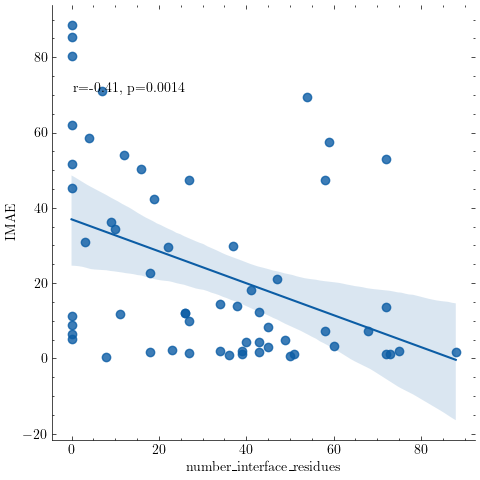

In [118]:
g = sns.lmplot(data=df2, x='number_interface_residues', y='IMAE')

g.map_dataframe(annotate)

<Axes: xlabel='capri', ylabel='IMAE'>

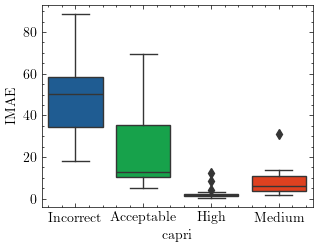

In [119]:
sns.boxplot(data=df2, x='capri', y='IMAE')

Based on this, it would be smart to use the structures with the most interface contacts as the "native" in a DockQ analysis, with the exception of those proteins that have no structures in the closed conformation. In that case, use the one with the lowest IMAE.

## How well does AlphaFold2 perform?

How many structures does AlphaFold2 match to within 3 Angstroms?

In [120]:
best_alpha = g3d[g3d['complex_rmsd'] <= 3]
best_alpha['uniprot'].nunique()

18

In [121]:
best_alpha['state'].value_counts()

Active           10
Autoinhibited     7
Name: state, dtype: int64

In [122]:
best_uniprots = best_alpha['uniprot'].unique()
best = g3d[g3d['uniprot'].isin(best_uniprots)]
best.groupby('uniprot')['state'].value_counts()

uniprot     state        
A0A0R4I961  Active           2
O00571      Active           1
            Autoinhibited    1
P12931      Active           1
            Autoinhibited    1
P22681      Active           1
            Autoinhibited    1
P26358      Active           1
            Autoinhibited    1
P28482      Active           1
            Autoinhibited    1
P29350      Active           1
            Autoinhibited    1
P49137      Autoinhibited    1
P53042      Active           1
            Autoinhibited    1
P54646      Active           2
Q00944      Active           1
            Autoinhibited    1
Q96FI4      Active           1
Q9JK66      Active           2
Q9UGN5      Active           1
Q9UM73      Autoinhibited    1
Q9Y6K1      Active           1
            Autoinhibited    1
Name: state, dtype: int64

16 proteins. Not too bad.

Of all of our proteins, how many does AlphaFold2 match to within 3 angstroms?

In [123]:
best_all = df[df['complex_rmsd'] <= 3]
best_all['uniprot'].nunique()

75

Of our multi-domain proteins, how many does AlphaFold2 match to within 3 angstroms?

In [124]:
md_best = md[md['complex_rmsd'] <= 3]
print('The number of good fits for multi_domain proteins is ' + str(md_best['uniprot'].nunique()) + ' out of ' + str(md['uniprot'].nunique()) + ' proteins.')


The number of good fits for multi_domain proteins is 31 out of 40 proteins.


How many protein structures does AlphaFold match to within 3 Angstroms, when using the full-depth MSA?

• 16 structures. Therefore, for proteins for which we have at least two distinct experimental structures, AlphaFold2’s prediction fits one of them 55% of the time (based on IMAE; for the full complex, 18/29, or 62% of the time)

• For the rest of our 99 proteins, 50 of them have AlphaFold2-predicted structures within 3 Angstroms of an experimentally observed structure (51% for IMAE; for full complex, it is 59/99, or 60% of the time).

- For our multi-domain proteins, 31/40 proteins, or 78%, are experimentally accurate (based on complex RMSD)

## Do the clusters manage to fix this?

How many of our cluster structures are actually close to the experimental structures? 

In [125]:
pdbc = pd.read_csv('./project_pipeline/data/ai_pdb_cluster_compared.tsv', sep='\t')
pdbc = pdbc.rename(columns={'complex_rmsd': 'pdb_cl_complex_RMSD', '2_comp': 'pdb_cl_IMAE'})
pdbc = pdbc[['uniprot', 'pdb', 'cluster', 'pdb_cl_complex_RMSD', 'pdb_cl_IMAE']]

pdbc.head()

,uniprot,pdb,cluster,pdb_cl_complex_RMSD,pdb_cl_IMAE
0,P04637,8f2h,004,28.339,63.920
1,P04637,8f2h,000,31.787,95.323
2,P04637,8f2h,015,26.456,35.216
3,P04637,8f2h,009,27.241,51.250
4,P04637,8f2h,U100-003,34.649,98.816


In [126]:
# # get rid of uniformly clustered structures
# pdbc = pdbc[pdbc['cluster'].str.contains('U') == False]
# pdbc.head()

In [127]:
master = pd.merge(g3d, pdbc, on=['uniprot', 'pdb'], how='left')
master.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,IMAE,state,...,fnonnat,fnonnat_nnative,fnonnat_model,irms,lrms,dockq,capri,cluster,pdb_cl_complex_RMSD,pdb_cl_IMAE
0,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,1.0,21.0,21.0,5.269,20.171,0.075,Incorrect,U100-001,23.714,39.450
1,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,1.0,21.0,21.0,5.269,20.171,0.075,Incorrect,U10-003,25.014,36.199
2,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,1.0,21.0,21.0,5.269,20.171,0.075,Incorrect,U10-007,22.115,41.365
3,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,1.0,21.0,21.0,5.269,20.171,0.075,Incorrect,U100-008,19.668,21.314
4,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,1.0,21.0,21.0,5.269,20.171,0.075,Incorrect,U100-005,23.249,22.542


In [128]:
# How many of the cluster structures are accurate?
accurate = master[master['pdb_cl_IMAE'] <= 3]
print('The number of proteins with accurate cluster structures is ' + str(accurate['uniprot'].nunique()))
accurate.groupby('uniprot')['state'].value_counts()

The number of proteins with accurate cluster structures is 1


uniprot  state        
P29350   Active           8
         Autoinhibited    1
Name: state, dtype: int64

In [129]:
df7 = pd.merge(df, ifc, on=['uniprot', 'pdb'])
minimum = df7.groupby('uniprot')['IMAE'].min().reset_index()
minimum = pd.merge(df7, minimum, on=['uniprot', 'IMAE'], how='left')
minimum.sort_values(by=['IMAE', 'number_interface_residues'], ascending=False).head(15)

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,IMAE,state,...,chain,af_filename,nstds,non-polymers,has_partner,num_partners,has_nstds,has_nplymrs,diff,number_interface_residues
734,P35609,4d1e,259-307,753-824,113.774,100.000000,100.000000,4.342,220.629,Autoinhibited,...,A,F-P35609-F1-model_v3.cif,['N-METHYL-LYSINE'],[],False,0,True,False,0.000,NaN
833,Q99683,8qgy,1-648,680-938,29.474,82.716049,87.258687,2.389,119.244,NaN,...,A,F-Q99683-F1-model_v3.cif,[],[],False,0,False,False,0.000,2.0
805,Q9Y490,6r9t,1654-2344,86-403,33.033,100.000000,60.062893,3.839,99.059,NaN,...,A,F-Q9Y490-F1-model_v3.cif,[],[],False,0,False,False,0.000,44.0
687,P53041,8gae,"28-129,487-499",184-486,25.904,88.695652,98.019802,2.339,88.629,Active,...,E,F-P53041-F1-model_v3.cif,"[""ADENOSINE-5'-DIPHOSPHATE"", 'PHOSPHOSERINE']","[""ADENOSINE-5'-TRIPHOSPHATE"", 'POTASSIUM ION',...",True,3,True,True,3.185,NaN
688,P53041,8gft,"28-129,487-499",184-486,24.876,88.695652,98.019802,2.358,85.444,Active,...,E,F-P53041-F1-model_v3.cif,"[""ADENOSINE-5'-DIPHOSPHATE"", 'PHOSPHOSERINE']","[""ADENOSINE-5'-TRIPHOSPHATE"", 'POTASSIUM ION',...",True,3,True,True,3.185,NaN
776,Q96P20,7vtp,740-991,220-536,22.263,100.000000,94.637224,14.386,80.422,NaN,...,A,F-Q96P20-F1-model_v3.cif,"[""ADENOSINE-5'-DIPHOSPHATE""]",['1-[4-(2-oxidanylpropan-2-yl)furan-2-yl]sulfo...,False,0,True,True,73.975,NaN
775,Q96P20,7pzc,740-991,220-536,37.197,100.000000,100.000000,16.214,80.408,NaN,...,A,F-Q96P20-F1-model_v3.cif,"[""ADENOSINE-5'-DIPHOSPHATE""]","['1-(1,2,3,5,6,7-hexahydro-s-indacen-4-yl)-3-[...",False,0,True,True,73.975,NaN
780,Q96P20,8swk,740-991,220-536,22.336,100.000000,97.476341,15.807,80.056,NaN,...,A,F-Q96P20-F1-model_v3.cif,[],['1-[4-(2-oxidanylpropan-2-yl)furan-2-yl]sulfo...,False,0,False,True,73.975,NaN
777,Q96P20,7zgu,740-991,220-536,21.005,100.000000,98.422713,15.636,78.651,NaN,...,A,F-Q96P20-F1-model_v3.cif,"[""ADENOSINE-5'-DIPHOSPHATE""]",[],False,0,True,False,73.975,NaN
781,Q96P20,8sxn,740-991,220-536,21.268,100.000000,97.476341,15.818,78.001,NaN,...,C,F-Q96P20-F1-model_v3.cif,[],['1-[4-(2-oxidanylpropan-2-yl)furan-2-yl]sulfo...,True,1,False,True,73.975,NaN
